## Arquitecturas comunes

Algunas arquitecturas comunes son:
- Stem-body-head: meta-arquitectura típica de las CNNs modernas, profundas normalmente.
  - Stem -> dos o tres capas convolucionales que extraen características de bajo nivel.
  - Body -> subred de bloques convolucionales.
  - Head -> transforma la salida del cuerpo según la tarea a abordar

## CIFAR-10

In [1]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'; import keras; import keras_cv
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.cifar10.load_data()

2024-12-11 00:10:01.060287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 00:10:01.080977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 00:10:01.085728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/home/yassin/anaconda3/envs/per/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


[[6 9 9 4 1 1 2 7 8 3]]


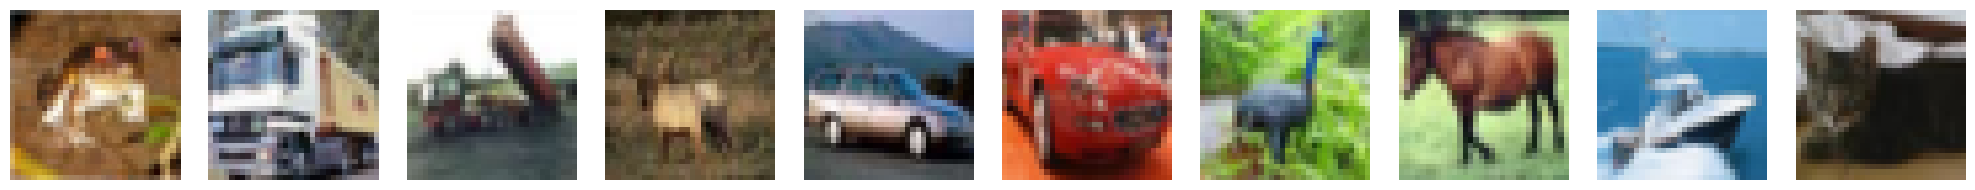

In [2]:
rows = 1; cols = 10; scale = 2
print(y_train_val[:rows*cols].T)
keras_cv.visualization.plot_image_gallery(
    np.array(x_train_val[:rows*cols]), rows=rows, cols=cols, value_range=(0, 255), show=True, scale=scale)

In [6]:
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")
y_train_val = keras.utils.to_categorical(y_train_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


### Una Convolutional Neural Network sencilla...

Inicialización, semilla y lectura de CIFAR-10 y partición train-val-test

In [8]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; from keras import layers; import keras_tuner
keras.utils.set_random_seed(23)
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")
y_train_val = keras.utils.to_categorical(y_train_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


Hipermodelo basado en el FashionMNIST

In [10]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    input_shape = (32, 32, 3)
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    filters = 32
    conv = layers.Conv2D(filters, kernel_size=(3, 3), activation="relu")(x)
    pooling = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(2*filters, kernel_size=(3, 3), activation="relu")(pooling)
    pooling = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    dropout = 0.5

    x = layers.Flatten()(pooling)
    x = layers.Dense(units=800, activation='relu')(x)
    x = layers.Dropout(dropout)(x)

    predictions = layers.Dense(10, activation='softmax')(x)

    M = keras.models.Model(inputs=inputs, outputs=predictions)
    learning_rate = hp.Float("learning rate", min_value=0.001, max_value=0.002)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M

  def fit(self, hp, M, x, y, xy_val, **kwargs):
    factor = 0.38; patience = 5
    reduce_cb = keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=factor, patience=patience, min_delta=0.0, min_lr=0.0)

    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=0)
    
    kwargs['callbacks'].extend([reduce_cb, early_cb])
    return M.fit(x, y, batch_size=256, epochs=100, validation_data=xy_val, **kwargs)

In [11]:
tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(), objective="val_accuracy", max_trials=10, executions_per_trial=1,
    overwrite=True, directory="/tmp", project_name="CIFAR-10")

In [ ]:
tuner.search(x_train, y_train, (x_val, y_val))
tuner.results_summary(num_trials=3)

In [ ]:
num_models = 10
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=num_models)
best_models = tuner.get_best_models(num_models=num_models)
for m in range(num_models):
    values = best_hyperparameters[m].values
    score = best_models[m].evaluate(x_test, y_test, verbose=0)
    print(f'Model {m}: Hyperparameters: {values!s} Loss: {score[0]:.4} Precisión: {score[1]:.2%}')

Los resultados distan mucho de las precisiones que pueden conseguirse con redes profundas

## ResNet

Se trata de una red residual profunda pequeña y preentranada en image-net

In [14]:
import numpy as np; import matplotlib.pyplot as plt; import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; from keras.applications.resnet_v2 import ResNet50V2
M = ResNet50V2(include_top=True, weights='imagenet')
print('Primeras capas de un total de', len(M.layers),'\n')
# lines = []; M.summary(line_length=120, print_fn=lambda x: lines.append(x)); summary = '\n'.join(lines)
M.summary(line_length=95, positions=[0.38, 0.66, 0.78, 1.], show_trainable=True, layer_range=('input', 'pool1'))


102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Primeras capas de un total de 192 



Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃ Param # ┃ Connected to    ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)   │       0 │ -               │    -    │
├───────────────────────────────┼───────────────────────┼─────────┼─────────────────┼─────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)   │       0 │ input_layer_1[… │    -    │
├───────────────────────────────┼───────────────────────┼─────────┼─────────────────┼─────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)  │   9,472 │ conv1_pad[0][0] │    Y    │
├───────────────────────────────┼───────────────────────┼─────────┼─────────────────┼─────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)  │       0 │ conv1_conv[0][… │    -    │
├───────────────────────────────┼───────────────────────┼─────────┼─────────────────┼─────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)    │       0 │ pool1_pad[0][0] │    -    │
└───────────────────────────────┴───────────────────────┴─────────┴─────────────────┴─────────┘

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
import tensorflow_datasets as tfds
from keras.preprocessing.image import smart_resize, img_to_array
from keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
ds = tfds.load('imagenet_v2', split='test', as_supervised=True)
N = 16; ds = ds.take(N); nrows = 1; ncols = 6
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5*ncols, 1.5*ncols), constrained_layout=True)
for ax, img_label in zip(axs.flat, ds.as_numpy_iterator()):
    ax.set_axis_off(); ax.imshow(img_label[0], interpolation="none")
    img = np.expand_dims(img_to_array(smart_resize(img_label[0], M.input_shape[1:-1])), axis=0)
    pred = np.squeeze(decode_predictions(M.predict(preprocess_input(img), verbose=0), top=1))
    ref = np.squeeze(decode_predictions(np.eye(1, 1000, img_label[1]), top=1))
    ax.set_title(f'{pred[1]} {pred[2]:.6}\n{ref[1]}', fontsize=9)


## Transfer learning

Cargamos los datos

In [1]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; from keras import layers
keras.utils.set_random_seed(23)
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")
y_train_val = keras.utils.to_categorical(y_train_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)


2024-12-11 00:41:05.673566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733874065.763036  390542 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733874065.778757  390542 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


Construimos el modelo

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
x = layers.Resizing(224, 224, interpolation="nearest")(x)
base_M = keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_M.trainable = False
x = base_M(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=800, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(10, activation='softmax')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


2024-12-11 00:41:40.745833: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Guardamos el mejor modelo con un callback checkpoint

In [ ]:
filename = 'CIFAR10_transfer_learning.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(x_train, y_train, batch_size=32, epochs=500, validation_data=(x_val, y_val), verbose=0,
    callbacks=[checkpoint_cb, early_cb, reduce_cb])

Mostramos los resultados

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid();  # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', label='train')
ax.plot(xx, H.history['val_loss'], color='r', label='val'); ax.legend()
ax = axes[1]; ax.grid(); # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', label='val'); ax.legend()

In [ ]:
score = keras.models.load_model(filename).evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4} Precisión: {score[1]:.2%}')

Los resultados son mucho mejores que con una red sencilla

## Fine Tuning

Cargamos datos

In [4]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; from keras import layers
keras.utils.set_random_seed(23)
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")
y_train_val = keras.utils.to_categorical(y_train_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)


(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


Re-entrenamos suavemente el modelo

In [ ]:
M = keras.models.load_model('CIFAR10_transfer_learning.keras')
M.trainable = True
for layer in M.layers:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
opt = keras.optimizers.Adam(learning_rate=1e-5)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
filename = 'CIFAR10_fine-tuning.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=0,
    callbacks=[checkpoint_cb, early_cb, reduce_cb])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid();  # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', label='train')
ax.plot(xx, H.history['val_loss'], color='r', label='val'); ax.legend()
ax = axes[1]; ax.grid(); # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', label='val'); ax.legend()

In [ ]:
score = keras.models.load_model(filename).evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4} Precisión: {score[1]:.2%}')